In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.stats.utils import pval2sig
from sigcorr.tools.stats.utils import sig2pval
from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level
from sigcorr.tools.stats.gp.euler_number import GPEulerNumberPropagator

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import EulerNumberCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import OverflowsCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [11]:
input_file = "../../output/hyy2d_dense-100k.h5"
asimov_input_file = input_file.split("-")[0]+"-asimov.h5"

In [12]:
true_model = Hyy2D(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [13]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:10_000, ...]
    #true_res_part["sig_std"] = f.attrs["sig_std"]

In [14]:
asimov_model = Hyy2DAsimov(true_model.xs)
set_params_from_file(asimov_model, asimov_input_file)
asimov_model.init()

In [15]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [16]:
asimov_samples = asimov_res["bg_samples"]

In [17]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3458.78it/s]


In [18]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19071.93it/s]


In [19]:
LOCAL_SIG_GRID = np.arange(0, 7.05, 0.1)

In [20]:
c0 = LOCAL_SIG_GRID[7]
c1 = LOCAL_SIG_GRID[10]

In [21]:
asimov_gp_euler_number_covcalc0, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 100_000, 300, true_res_part["scan_xs"].shape[:-1], EulerNumberCalc(c0), BatchStats1Reduce()))
asimov_gp_euler_number0, asimov_gp_euler_number_err0 = asimov_gp_euler_number_covcalc0.get_mean(), asimov_gp_euler_number_covcalc0.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100200/100200 [00:44<00:00, 2250.48it/s]


In [22]:
asimov_gp_euler_number_covcalc1, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 100_000, 300, true_res_part["scan_xs"].shape[:-1], EulerNumberCalc(c1), BatchStats1Reduce()))
asimov_gp_euler_number1, asimov_gp_euler_number_err1 = asimov_gp_euler_number_covcalc1.get_mean(), asimov_gp_euler_number_covcalc1.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100200/100200 [00:49<00:00, 2019.88it/s]


In [23]:
[asimov_gp_euler_number0, asimov_gp_euler_number1]

[array([4.61387]), array([3.87234])]

In [24]:
asimov_gp_euler_number_err0, asimov_gp_euler_number_err1

(array([0.01519643]), array([0.01286552]))

In [25]:
true_euler_number_covcalc0, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 1000, ChainCalc([SigsCalc(), EulerNumberCalc(c0)]), BatchStats1Reduce()))
true_euler_number0, true_euler_number_err0 = true_euler_number_covcalc0.get_mean(), true_euler_number_covcalc0.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 65494.00it/s]


In [26]:
true_euler_number_covcalc1, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 1000, ChainCalc([SigsCalc(), EulerNumberCalc(c1)]), BatchStats1Reduce()))
true_euler_number1, true_euler_number_err1 = true_euler_number_covcalc1.get_mean(), true_euler_number_covcalc1.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 71526.28it/s]


In [27]:
[true_euler_number0, true_euler_number1]

[array([4.60806]), array([3.87154])]

In [28]:
true_euler_number_err0, true_euler_number_err1

(array([0.01518052]), array([0.0128607]))

In [29]:
asimov_propagator = GPEulerNumberPropagator(np.array([c0, c1]).ravel(), np.array([asimov_gp_euler_number0, asimov_gp_euler_number1]).ravel())

In [30]:
gv_p0_upper_bound = asimov_propagator.calc(LOCAL_SIG_GRID)
gv_p0_upper_bound

array([4.83219669e+00, 4.94893228e+00, 5.01818922e+00, 5.03721028e+00,
       5.00488537e+00, 4.92180233e+00, 4.79020608e+00, 4.61387000e+00,
       4.39788978e+00, 4.14841528e+00, 3.87234000e+00, 3.57696947e+00,
       3.26969055e+00, 2.95766166e+00, 2.64754108e+00, 2.34526633e+00,
       2.05589259e+00, 1.78349337e+00, 1.53112198e+00, 1.30082812e+00,
       1.09372121e+00, 9.10069974e-01, 7.49426809e-01, 6.10765906e-01,
       4.92624772e-01, 3.93240560e-01, 3.10674468e-01, 2.42919572e-01,
       1.87989463e-01, 1.43986842e-01, 1.09152708e-01, 8.18978714e-02,
       6.08192345e-02, 4.47036760e-02, 3.25224356e-02, 2.34187594e-02,
       1.66912568e-02, 1.17750224e-02, 8.22214414e-03, 5.68279589e-03,
       3.88772494e-03, 2.63262060e-03, 1.76458652e-03, 1.17074456e-03,
       7.68861865e-04, 4.99808761e-04, 3.21611136e-04, 2.04848213e-04,
       1.29154429e-04, 8.06054696e-05, 4.97966120e-05, 3.04520876e-05,
       1.84339407e-05, 1.10459974e-05, 6.55207768e-06, 3.84717696e-06,
      

In [31]:
true_p0_bs, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 20000, ChainCalc([SigsCalc(), OverflowsCalc(LOCAL_SIG_GRID)]), BatchStats1Reduce()))
true_p0, true_p0_err = true_p0_bs.get_mean(), true_p0_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2901.58it/s]


In [32]:
true_p0

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9999e-01,
       9.9984e-01, 9.9955e-01, 9.9806e-01, 9.9475e-01, 9.8640e-01,
       9.7014e-01, 9.4368e-01, 9.0420e-01, 8.5157e-01, 7.8576e-01,
       7.1109e-01, 6.3024e-01, 5.4666e-01, 4.6497e-01, 3.8861e-01,
       3.1955e-01, 2.5952e-01, 2.0639e-01, 1.6180e-01, 1.2413e-01,
       9.4720e-02, 7.0750e-02, 5.3190e-02, 3.8960e-02, 2.8520e-02,
       2.0410e-02, 1.4280e-02, 1.0050e-02, 6.9100e-03, 4.8300e-03,
       3.3400e-03, 2.2100e-03, 1.5700e-03, 9.6000e-04, 6.7000e-04,
       4.7000e-04, 2.9000e-04, 1.6000e-04, 1.1000e-04, 5.0000e-05,
       4.0000e-05, 2.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
       1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00])

In [33]:
true_p0_err

array([3.16226185e-03, 3.16226185e-03, 3.16226185e-03, 3.16226185e-03,
       3.16226185e-03, 3.16226185e-03, 3.16226185e-03, 3.16226185e-03,
       3.16226185e-03, 3.16224604e-03, 3.16200886e-03, 3.16155027e-03,
       3.15919300e-03, 3.15395007e-03, 3.14068507e-03, 3.11469194e-03,
       3.07192300e-03, 3.00697826e-03, 2.91815481e-03, 2.80313008e-03,
       2.66661760e-03, 2.51045021e-03, 2.33806974e-03, 2.15631129e-03,
       1.97131552e-03, 1.78759330e-03, 1.61096035e-03, 1.43662651e-03,
       1.27200526e-03, 1.11413575e-03, 9.73241544e-04, 8.41129895e-04,
       7.29314553e-04, 6.24179340e-04, 5.34041121e-04, 4.51774234e-04,
       3.77888846e-04, 3.17017334e-04, 2.62868779e-04, 2.19772604e-04,
       1.82756666e-04, 1.48660686e-04, 1.25299640e-04, 9.79795892e-05,
       8.18535274e-05, 6.85565458e-05, 5.38516480e-05, 4.00000000e-05,
       3.31662479e-05, 2.23606798e-05, 2.00000000e-05, 1.41421356e-05,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 1.00000000e-05,
      

In [42]:
gp_p0_bs, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 300, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0, gp_p0_err = gp_p0_bs.get_mean(), gp_p0_bs.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [07:01<00:00, 7123.88it/s]


In [35]:
deviation = 10*(asimov_corr - true_corr)
deviation[np.eye(deviation.shape[0]).astype(bool)] = 0

In [43]:
gp_p0UP_bs, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr + deviation, 3_000_000, 300, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0UP, gp_p0UP_err = gp_p0UP_bs.get_mean(), gp_p0UP_bs.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [06:56<00:00, 7196.24it/s]


In [44]:
gp_p0DOWN_bs, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr - deviation, 3_000_000, 300, true_res_part["scan_xs"].shape[:-1], OverflowsCalc(LOCAL_SIG_GRID), BatchStats1Reduce()))
gp_p0DOWN, gp_p0DOWN_err = gp_p0DOWN_bs.get_mean(), gp_p0DOWN_bs.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [06:56<00:00, 7198.97it/s]


In [45]:
LOCAL_PVALS = sig2pval(LOCAL_SIG_GRID)

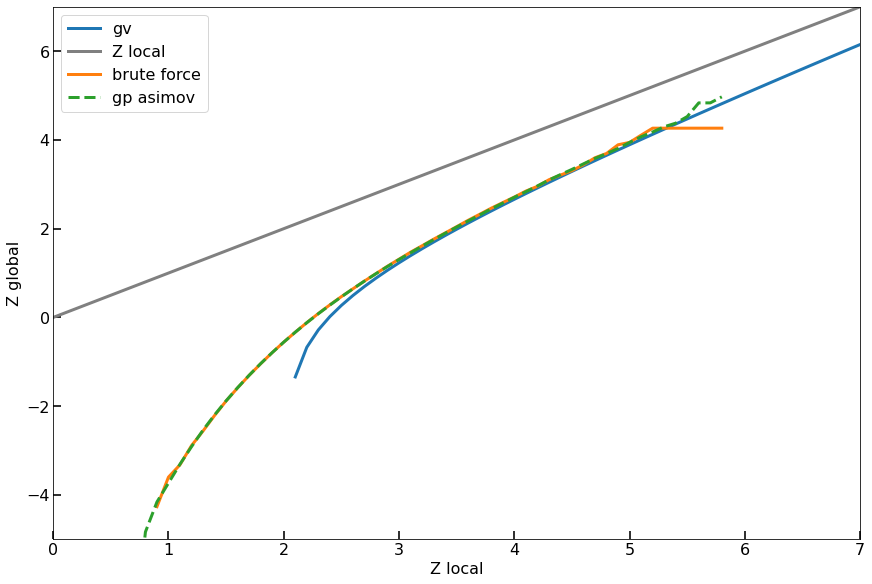

In [46]:
plt.plot(LOCAL_SIG_GRID, pval2sig(gv_p0_upper_bound), label="gv")
plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.plot(LOCAL_SIG_GRID, pval2sig(true_p0), ls="-", label="brute force")
plt.plot(LOCAL_SIG_GRID, pval2sig(gp_p0), ls="--", label="gp asimov")
plt.legend()
plt.ylim(-5, 7)
plt.xlim(0, 7);
plt.ylabel("Z global")
plt.xlabel("Z local");

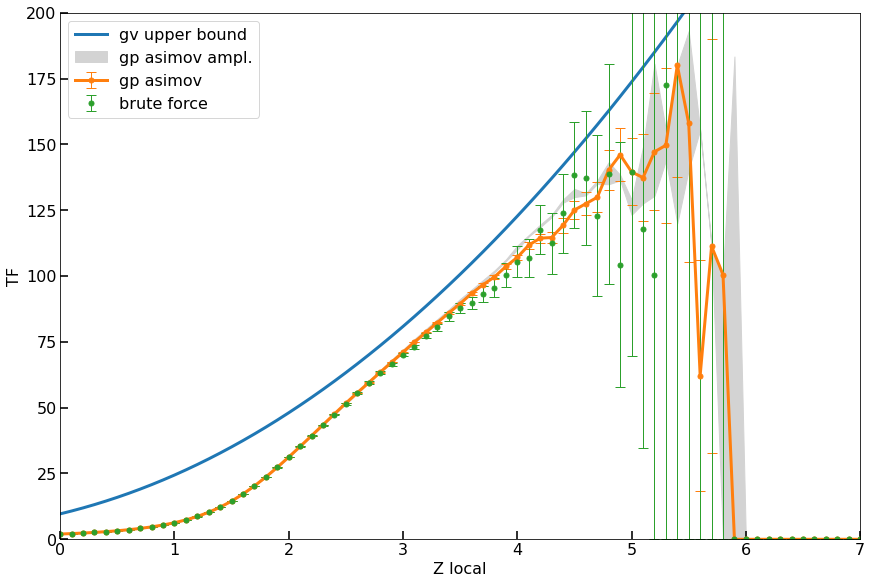

In [47]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound/LOCAL_PVALS, label="gv upper bound")
#plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.fill_between(LOCAL_SIG_GRID, np.min([gp_p0DOWN, gp_p0UP], axis=0)/LOCAL_PVALS, np.max([gp_p0DOWN, gp_p0UP], axis=0)/LOCAL_PVALS, color="lightgray", label="gp asimov ampl.")
plt.errorbar(LOCAL_SIG_GRID, gp_p0/LOCAL_PVALS, ls="-", yerr=gp_p0_err/LOCAL_PVALS, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0/LOCAL_PVALS, yerr=true_p0_err/LOCAL_PVALS, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.axhline((true_res_part["scan_xs"][-1] - true_res_part["scan_xs"][0])/true_res_part["sig_std"], color="gray", label="$\Delta m/\sigma_m$")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound/LOCAL_PVALS, ls="--", label="direct asimov upper bound")
plt.legend()
#plt.yscale("log")
plt.ylim(0, 200)
plt.xlim(0, 7);
plt.ylabel("TF")
plt.xlabel("Z local");

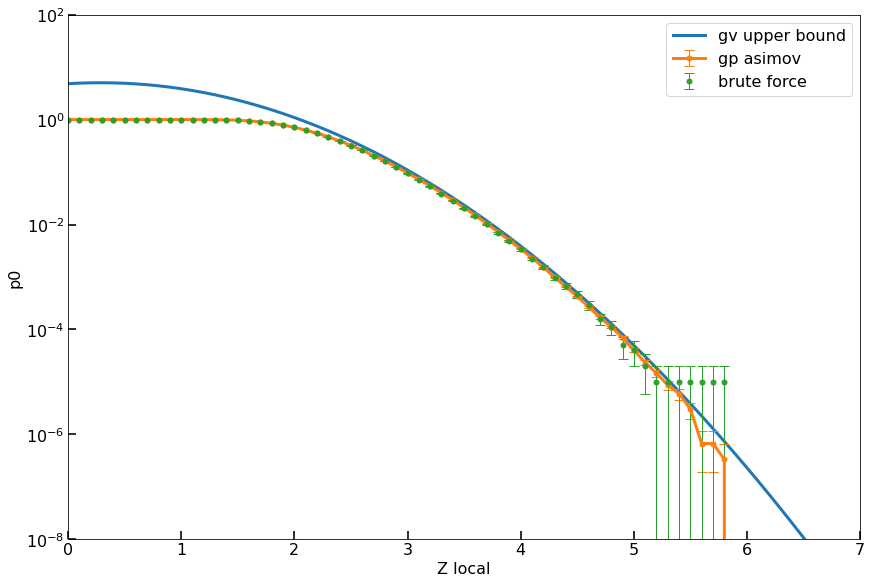

In [48]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound, label="gv upper bound")
plt.errorbar(LOCAL_SIG_GRID, gp_p0, ls="-", yerr=gp_p0_err, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0, yerr=true_p0_err, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound, ls="--", label="direct asimov upper bound")
plt.legend()
plt.yscale("log")
plt.ylim(1E-8, 100)
plt.xlim(0, 7);
plt.ylabel("p0")
plt.xlabel("Z local");